In [63]:
from __future__ import print_function, division

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path
import copy
import torchsummary
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm
from barbar import Bar
cudnn.benchmark = True
plt.ion()   # interactive mode

selected_gpu = 1 # here you select the GPU used (0, 1 or 2)
device = torch.device("cuda:" + str(selected_gpu) if
torch.cuda.is_available() else "cpu")
print(f'the device is {device}')


the device is cpu


In [26]:
#if running locally
notebook_path = Path().cwd()
#if running in colab
# from google.colab import drive
# drive._mount('/content/drive')
#notebook_path = Path('/content/drive/MyDrive/MAIA/3rd_semester/CAD/Projecte/Deep_Learning/notebooks')

project_path = notebook_path.parent
repo_path = project_path.parent
os.chdir(notebook_path)
print(f'The current directory is {Path().cwd()}')

The current directory is /home/ricardino/Documents/MAIA/tercer_semestre/CAD/Projecte/Deep_Learning/notebooks


# MAIN

## Hyperparameters
- For both preprocessing and training

In [61]:
#@markdown ## Hyperparameters
batch_size =  8 #@param
learning_rate =  1e-5 #@param
num_workers =  4 #@param
num_epochs =  10 #@param

#early stopping
patience = 10 #@param

#challenge type (binary or 3-classes)
num_classes = 2 #@param

#image size 
height = 450
width = 600

#cropping
center_crop = 448

## Datatransforms
- Define the preprocessing steps and the data augmentation approaches

In [43]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((height, width)),
        transforms.CenterCrop(center_crop), #because the information of the image is centered all the time
        transforms.RandomAffine(90,shear=20,scale=(0.8,1.2)), #random affine homographies
        transforms.RandomHorizontalFlip(), #flips
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=(0.7,1.3), contrast=(0.7,1.3), saturation=(0.7,1.3)), #changing color brightness, contrast and saturation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Imagenet mean and std
    ]),
    'val': transforms.Compose([ #for validation we only resize and crop
        transforms.Resize((height, width)),
        transforms.CenterCrop(center_crop),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ #for test we only resize and crop
        transforms.Resize((height, width)),
        transforms.CenterCrop(center_crop),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Dataloading

In [44]:
#directory of the data
data_dir = repo_path /'Machine_Learning'/'images' / 'binary'
folders_list = ['train', 'val', 'test']

#get the data info
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in folders_list}
#get dataloader
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
              for x in folders_list}
#size of datasets
dataset_sizes = {x: len(image_datasets[x]) for x in folders_list}
#get classes names
class_names = image_datasets['train'].classes

## Visualizing some images

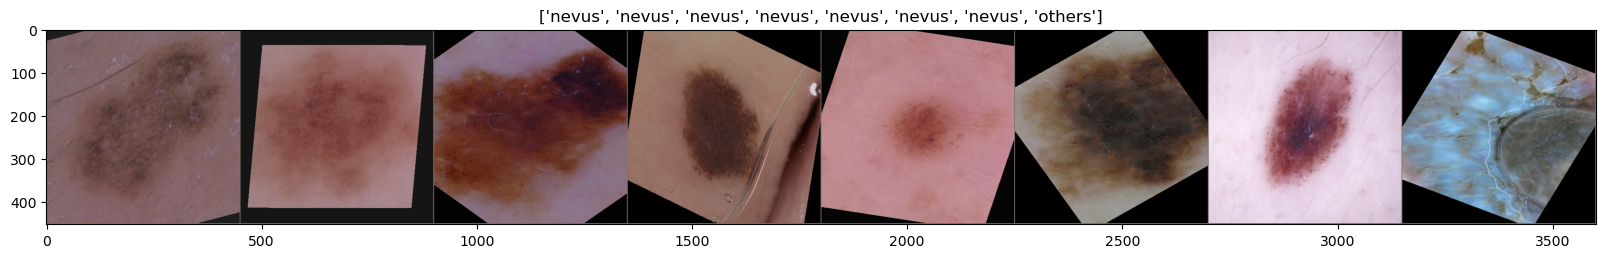

In [45]:
def imshow(input:torch.Tensor, title=None):
    """shows a preprocessed tensor in its original form

    Args:
        input (torch.Tensor): input tensor
        title (_type_, optional): _description_. Defaults to None.
    """
    #get numpy, and put color at the end
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #scale back
    input = std * input + mean
    input = np.clip(input, 0, 1)
    #plot
    plt.figure(figsize=(20,10))
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid (fused_image) from batch
out = torchvision.utils.make_grid(inputs)
#show the fused_image
imshow(out, title=[class_names[x] for x in classes])

## Analysing the architecture of the network

In [48]:
# Viewing the Architecture and Finding the Cross-Section of Transfer Learning
sample_net = torchvision.models.googlenet(weights='DEFAULT') 
torchsummary.summary(sample_net, (3, 448, 448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
       BasicConv2d-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]           4,096
       BatchNorm2d-6         [-1, 64, 112, 112]             128
       BasicConv2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 192, 112, 112]         110,592
       BatchNorm2d-9        [-1, 192, 112, 112]             384
      BasicConv2d-10        [-1, 192, 112, 112]               0
        MaxPool2d-11          [-1, 192, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          12,288
      BatchNorm2d-13           [-1, 64, 56, 56]             128
      BasicConv2d-14           [-1, 64,

## Model setting

In [37]:
model_name = 'googlenet'
#get the model
model = getattr(torchvision.models, model_name)(weights='DEFAULT')
#change last layer to have two outputs
in_fts_fc = model.fc.in_features
model.fc = nn.Linear(in_fts_fc, num_classes)
#send model to device
model = model.to(device)
#saving path
model_save_path = project_path / 'data'/'models'/'binary' / f'{model_name}.pt'

## Useful functions

In [41]:
def get_accuracy(predicted, labels):
    """gets the accuracy of a batch

    Args:
        predicted (_type_): predicted labels
        labels (_type_): true labels

    Returns:
        int, int: batch length, correct predictions
    """
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_dataloader, criterion):
    """gets validation losses and accuracy

    Args:
        model (_type_): model trained
        val_dataloader (_type_): data loader for validation
        criterion (_type_): loss function

    Returns:
        float, float: losses and accuracy of validation set
    """
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_dataloader)
    return losses, accuracy

class EarlyStopping:
    """Early Stops the Training if the Validation Loss doesn't improve after a predefined Patience."""
    def __init__(self, patience=7, verbose=False, delta=0):

        self.patience     = patience
        self.verbose      = verbose
        self.counter      = 0
        self.best_score   = None
        self.early_stop   = False
        self.val_loss_min = np.Inf
        self.delta        = delta

    def __call__(self, val_loss, model, model_save_path):
        """what to do when calling the class

        Args:
            val_loss (_type_): validation loss
            model (_type_): trained model
            model_save_path (Path): path to save the model state dict
        """

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_save_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping Counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_save_path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, model_save_path):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation Loss Decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), model_save_path)
        self.val_loss_min = val_loss

## Training

Start by defining:
- Checkpoint model
- loss function
- optimizer
- scheduler

In [60]:
load_checkpoint  = False
print("Training with: " + model_name + "\nCheckpoint status : " + str(load_checkpoint))

#loss function and optimizer, with scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')

Training with: googlenet
Checkpoint status : False


In [65]:
# Initializing the early_stopping
early_stopping = EarlyStopping(patience=patience, verbose=True)

#list to store statistics
accuracy      = []
val_accuracy  = []
losses        = []
val_losses    = []
best_accuracy = 0

for epoch in range(num_epochs): #going through the dataset multiple times
    running_loss      = 0.0
    correct_total     = 0.0
    num_samples_total = 0.0
    for i, data in enumerate(tqdm(dataloaders['train'])):
        # Getting the Inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Setting the Parameter Gradients to Zero
        optimizer.zero_grad()

        # Forward Pass + Backward Pass + Optimize
        outputs = model(inputs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Computing Accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    running_loss /= len(dataloaders['train'])
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(model, dataloaders['val'])
    scheduler.step(val_loss)
    
    print(f'Epoch: {epoch+1}')
    print('Training Loss: %.3f , Training Accuracy:%.3f => Validation Loss: %.3f, Validation Accuracy: %.3f ' %(running_loss, train_accuracy,val_loss, val_acc))

    losses.append(running_loss)     # List Containing the Training Losses
    val_losses.append(val_loss)     # List Containing the Validation Losses
    accuracy.append(train_accuracy) # List Containing the Training Accuracy
    val_accuracy.append(val_acc)    # List Containing the Validation Accuracy

    # early_stopping needs Validation Loss to check if it decreases and if so, it makes a Checkpoint of the Current Model
    early_stopping(val_loss, model, model_save_path)
    
    if early_stopping.early_stop:
        print("Early Stopping")
        break

print('Finished Training')

 13%|█▎        | 242/1900 [08:17<56:50,  2.06s/it]  


KeyboardInterrupt: 